# Set Up Environment



In [25]:
!pip install rdkit python-dotenv pandas numpy matplotlib loguru py3dmol

In [1]:
import os
import pickle
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import requests

from dotenv import load_dotenv

from rdkit import Chem
from rdkit.Chem.QED import qed as rdkit_qed
from rdkit.Chem.QED import qed
from rdkit.Chem import AllChem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.Chem import Descriptors

from IPython.display import display, clear_output

API Key and URL

In [2]:
# --- Load environment variables from .env file ---
load_dotenv()

# --- Access your API key ---
API_KEY = os.getenv("API_KEY")

if API_KEY:
    print("NVIDIA API Key loaded successfully.")
else:
    print("NVIDIA API Key not found. Make sure it's set in your .env file or as a system environment variable.")
    raise ValueError("API_KEY is not set. Please create a .env file with your API_KEY.")

# --- API Setup ---
invoke_url = "https://health.api.nvidia.com/v1/biology/nvidia/molmim/generate"
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Accept": "application/json",
}
session = requests.Session()

NVIDIA API Key loaded successfully.


# Starting Molecule

Original QED: 0.7638626046471743


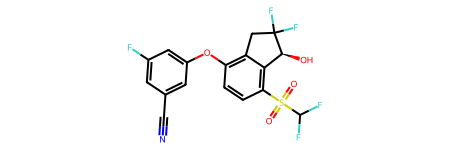

In [13]:
# Input SMILE string
smis = "C1C2=C(C=CC(=C2[C@@H](C1(F)F)O)S(=O)(=O)C(F)F)OC3=CC(=CC(=C3)C#N)F"

mol = Chem.MolFromSmiles(smis)
qed_score = rdkit_qed(mol)
print(f"Original QED: {qed_score}")
mol

## CMA-ES Optimization

In [14]:
# Create a dictionary to store the results
results = {}

# Create a list of minimum similarities
num_min_sims = 3
min_sims = np.linspace(0.1, 0.7, num_min_sims)

In [15]:
def tanimoto_similarity(smiles, reference: str):
    # Get fingerprint params
    fingerprint_radius_param = 2
    fingerprint_nbits = 2048

    # Handle the reference molecule
    reference_mol = Chem.MolFromSmiles(reference)
    reference_fingerprint = GetMorganFingerprintAsBitVect(
        reference_mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits
    )

    # Validate the other molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0

    fingerprint = GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits)

    # Calculate and return the Tanimoto similarity
    return TanimotoSimilarity(fingerprint, reference_fingerprint)

In [16]:
# Loop through each minimum similarity value
for min_sim in min_sims:
    # Create a dictionary to store the results for this min_sim
    min_sim_results = {'smiles': [], 'num_smiles': [], 'tanimoto_similarity': [], 'qed_score': []}

    # Create the request payload
    payload = {
      "smi": smis,
      "algorithm": "CMA-ES",
      "num_molecules": 10,
      "property_name": "QED",
      "minimize": False,
      "min_similarity": min_sim,
      "particles": 20,
      "iterations": 2,
      "scaled_radius": 1
    }

    # Send the request and get the response
    response = session.post(invoke_url, headers=headers, json=payload)
    response.raise_for_status()
    response_json = response.json()
    print(f"*************** min_sim: {min_sim} ********************")
    print(f"response_json: \n"
          f"{response_json}")

    # Extract the generated SMILES
    gen_smiles_list = [i['sample'] for i in ast.literal_eval(response_json['molecules'])]
    print(f"gen_smiles_list: \n"
          f"{gen_smiles_list}")
    
    # Get the molecule objects out of valid SMILES
    valid_mol_list = [mol for smiles in gen_smiles_list if (mol := Chem.MolFromSmiles(smiles))]
    
    # Convert to canonical SMILES & deduplicate
    canonical_smiles = set()
    for mol in valid_mol_list:
        canonical_smi = Chem.MolToSmiles(mol, canonical=True)
        canonical_smiles.add(canonical_smi)
    canonical_smiles_list = list(canonical_smiles)
    print(f"canonical_smiles_list: \n"
          f"{canonical_smiles_list}")

    # Calculate Tanimoto similarity and QED score for each valid SMILES
    for smiles in canonical_smiles_list:
        tanimoto = tanimoto_similarity(smiles, smis)
        mol = Chem.MolFromSmiles(smiles)
        qed_score = qed(mol)
        min_sim_results['tanimoto_similarity'].append(tanimoto)
        min_sim_results['qed_score'].append(qed_score)

    # Update min_sim_results - get the average of Tanimoto and QED scores, store generated SMILES
    min_sim_results['tanimoto_similarity'] = np.mean(min_sim_results['tanimoto_similarity'])
    min_sim_results['qed_score'] = np.mean(min_sim_results['qed_score'])
    min_sim_results['num_smiles'] = len(canonical_smiles_list)
    min_sim_results['smiles'] = canonical_smiles_list

    # Store the results for this min_sim
    results[min_sim] = min_sim_results

*************** min_sim: 0.1 ********************
response_json: 
{'molecules': '[{"sample": "CC1=CC(c2cccc3c2CCCC3)=C(C#N)[C@H]1C(=O)O", "score": 0.9008290538861267}, {"sample": "O=C(NS(=O)(=O)C[C@@H]1CCOC1)c1cc(=O)cc2ccccc2c1", "score": 0.900244244253867}, {"sample": "CCOC(=O)C1=C(C#N)C(=O)c2ccccc2N[C@@H]1C(F)(F)F", "score": 0.8460616211245658}, {"sample": "C[C@@H]1C=CC=c2c(=CC(=O)C3=CC=C(C(F)(F)F)OC3)ccn21", "score": 0.835739133105219}, {"sample": "C=C1C=CC(=O)C=C1NC(=O)C1=C(C)OC2=C(C1)O[C@@H](C(F)(F)F)C2", "score": 0.8290652751798779}, {"sample": "CCOC(=O)c1cc2ccccc2c(C#N)c1C(F)(F)F", "score": 0.7887797731144391}, {"sample": "CC1=C(C(=O)OCC2=Cc3cc(=O)cccc3CC2(F)F)CC(=O)O1", "score": 0.7847202815241617}, {"sample": "CS(=O)(=O)N=C1C=C[C@H]2C(=O)C=C(C(=O)OCC(F)(F)F)C=C12", "score": 0.7123110836567903}, {"sample": "C=C1C2=C(CC=CC=C2)C(=O)N1C1=CC(=O)[C@H](C(F)(F)F)C(F)(F)C1", "score": 0.6692415257949059}, {"sample": "O=C(C1C=CC=CC=C1C(F)(F)F)N1CC2(CCN(C(=O)[C@@H]3CC3(F)F)CC2)C1", "score

In [17]:
def physical_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # invalid SMILES

    # Calculate physical properties
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hba = Descriptors.NumHAcceptors(mol)
    hbd = Descriptors.NumHDonors(mol)
    tpsa = Descriptors.TPSA(mol)
    rotatable_bonds = Descriptors.NumRotatableBonds(mol)

    return mw, logp, hba, hbd, tpsa, rotatable_bonds

In [18]:

# Create a list to store the data for the report
report_data = []

for smiles in min_sim_results['smiles']:
    mol = Chem.MolFromSmiles(smiles)
    qed_score = qed(mol)
    tanimoto = tanimoto_similarity(smiles, smis)

    # Calculate Physical properties
    physical = physical_properties(smiles)
    if physical:
        mw, logp, hba, hbd, tpsa, rotatable_bonds = physical
    else:
        mw, logp, hba, hbd, tpsa, rotatable_bonds = None, None, None, None, None, None

    report_data.append({
        'smiles': smiles,
        'qed_score': qed_score,
        'tanimoto_similarity': tanimoto,
        'min_sim': min_sim,
        'mw': mw,
        'logp': logp,
        'hba': hba,
        'hbd': hbd,
        'tpsa': tpsa,
        'rotatable_bonds': rotatable_bonds
    })

# Create a pandas DataFrame from the report data
report_df = pd.DataFrame(report_data)

# Display the DataFrame
display(report_df)

# Save the DataFrame as a CSV file
csv_filename = 'min_sim_results_report.csv'
report_df.to_csv(csv_filename, index=False)
print(f"CSV report saved as '{csv_filename}'.")




,smiles,qed_score,tanimoto_similarity,min_sim,mw,logp,hba,hbd,tpsa,rotatable_bonds
0,Cn1cc([C@@H]2OC(=O)C(C(=O)N3CCC4(CC=CS4(=O)=O)...,0.506378,0.099010,0.7,445.419,1.57030,7,0,98.57,2
1,N#CC1(C(=O)OCC2=CC[C@H]3C(=O)N(CC(F)(F)F)C(=O)...,0.550476,0.138298,0.7,382.338,2.41738,5,0,87.47,4
2,CS(=O)(=O)C1=Cc2cc3c(cc2=C1)[C@H](C(F)(F)F)C=CC=3,0.793142,0.096386,0.7,312.312,1.86240,2,0,34.14,1
3,CC(C)(C)OS(=O)(=O)N1C(=c2c(F)cn3c(=O)c(F)c(F)c...,0.547012,0.174419,0.7,424.347,2.06840,5,0,68.09,2
4,O=S(=O)(C1=CC2(C=C1)[C@@H](C(F)(F)F)C2(F)F)C1C...,0.543134,0.125000,0.7,356.356,4.39150,2,0,34.14,2
5,N#CC(=c1ccc(=C2C3=C(CCC3)CC[C@H]2C(F)(F)F)cc1)...,0.615145,0.119048,0.7,371.324,4.52668,1,0,23.79,0
6,O=C(O)[C@@H]1C(=C2C=CC=C2)C=CC12CC(C(F)(F)F)=C...,0.533206,0.128205,0.7,362.269,4.88100,1,1,37.30,1
7,C=CCN1C(C)=C(C(=O)C2=CC3=CC=C[C@H](C(F)(F)F)C3...,0.715601,0.072165,0.7,369.364,3.15950,3,0,54.45,4
8,C#CCCCS(=O)(=O)N1CCc2ccc(=O)c(C(F)(F)F)cc2CC1,0.600712,0.113636,0.7,373.396,2.20940,3,0,54.45,4
9,N#CC1=CC=C[C@H]2C1=C(C#N)[C@@H](c1ccc(S(=O)(=O...,0.590924,0.180723,0.7,410.348,3.75726,4,1,101.95,2


CSV report saved as 'min_sim_results_report.csv'.


In [19]:
#uncomment to freeze requirements
!pip freeze > requirements.txt